# Chest X-Ray Medical Diagnosis with DenseNet121

We will set the preprocess data (as dataset C in article) follow to articles [Swarm Learning for decentralized and confidential clinical machine learning](https://www.nature.com/articles/s41586-021-03583-3#Sec23)

<a name='1'></a>
## Import Packages and Functions¶



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from os import listdir
from os.path import join, isfile, isdir
from glob import glob

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.densenet import DenseNet121
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras import backend as K

from PIL import Image
sns.set()
from tqdm import tqdm
%matplotlib inline

from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import random

import cv2
import matplotlib.pyplot as plt
import numpy as np
from keras import backend as K
from keras.preprocessing import image
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score, f1_score
from tensorflow.compat.v1.logging import INFO, set_verbosity

random.seed(a=None, version=2)
#The random.seed() function is a method in Python's random module that initializes the random number generator with a given seed value. 
#It allows you to generate a sequence of random numbers that can be replicated or reproduced in future runs, as long as the same seed value is used.


def get_roc_curve(labels, predicted_vals, generator):
    auc_roc_vals = []
    optimal_thresholds = []
    sensitivity = []
    specificity = []
    accuracy = []
    precision = []
    recall = []
    f1 = []
    for i in range(len(labels)):
        try:
            gt = generator.labels[:, i] 
            pred = predicted_vals[:, i]
            auc_roc = roc_auc_score(gt, pred) # return 
            auc_roc_vals.append(auc_roc)
            fpr, tpr, thresholds = roc_curve(gt, pred)
            optimal_idx = np.argmax(tpr - fpr)
            optimal_threshold = thresholds[optimal_idx]
            y_pred = pred > optimal_threshold
            acc = accuracy_score(gt, y_pred)
            prec = precision_score(gt, y_pred)
            rec = recall_score(gt, y_pred)
            f1_s = f1_score(gt, y_pred)
            accuracy.append(acc)
            precision.append(prec)
            recall.append(rec)
            f1.append(f1_s)
            optimal_thresholds.append(optimal_threshold) # find optimal thresholds https://stats.stackexchange.com/questions/123124/how-to-determine-the-optimal-threshold-for-a-classifier-and-generate-roc-curve
            optimal_tpr = round(tpr[optimal_idx],3)
            optimal_1_fpr = round(1 - fpr[optimal_idx],3)
#             print(f"Length of tpr tpr : {len(tpr)} \n Length of thresholds {len(thresholds)}")
#             print(f"optimal index : {optimal_idx} \n Optimal 1 - fpr : {optimal_1_fpr}")
            sensitivity.append(optimal_tpr)
            specificity.append(1-fpr[optimal_idx])
            plt.figure(1, figsize=(10, 10))
            plt.plot([0, 1], [0, 1], 'k--') # black dash line
            plt.plot(fpr, tpr,
                     label=labels[i] + " (" + str(round(auc_roc, 3)) + ")")
            plt.xlabel('False positive rate')
            plt.ylabel('True positive rate')
            plt.title('ROC curve')
            plt.legend(loc='best')
        except:
            print(
                f"Error in generating ROC curve for {labels[i]}. "
                f"Dataset lacks enough examples."
            )
    plt.show()
    return auc_roc_vals, optimal_thresholds, sensitivity, specificity, accuracy, precision, recall, f1



<a name='2'></a>
## Load the Datasets

For this assignment, we will be using the [ChestX-ray8 dataset](https://arxiv.org/abs/1705.02315) which contains 108,948 frontal-view X-ray images of 32,717 unique patients.
 

In [3]:
#test_df = pd.read_csv("../input/nih-chest-xray-dataset/test.csv")
#test_df.head()
all_xray_df = pd.read_csv("../input/chestxray8-dataframe/train_df.csv")
all_xray_df.drop(['No Finding'], axis = 1, inplace = True)
all_xray_df.head()

data_dir1 = '../input/data/'
data_dir2 = '../input/chestxray8-dataframe/'
train_df = pd.read_csv(data_dir1 + 'Data_Entry_2017.csv')
image_label_map = pd.read_csv(data_dir2 + 'train_df.csv')
bad_labels = pd.read_csv(data_dir2 + 'cxr14_bad_labels.csv')

# Listing all the .jpg filepaths
image_paths = glob(data_dir1+'images_*/images/*.png')
print(f'Total image files found : {len(image_paths)}')
print(f'Total number of image labels: {image_label_map.shape[0]}')
print(f'Unique patients: {len(train_df["Patient ID"].unique())}')

image_label_map.drop(['No Finding'], axis = 1, inplace = True)
labels = image_label_map.columns[2:-1]
labels


Total image files found : 112120
Total number of image labels: 111863
Unique patients: 30805


Index(['Cardiomegaly', 'Emphysema', 'Effusion', 'Hernia', 'Infiltration',
       'Mass', 'Nodule', 'Atelectasis', 'Pneumothorax', 'Pleural_Thickening',
       'Pneumonia', 'Fibrosis', 'Edema', 'Consolidation'],
      dtype='object')

In [4]:
all_xray_df = all_xray_df[89485:] # 22378 images

In [5]:
labels = ['Cardiomegaly', 
          'Emphysema', 
          'Effusion', 
          'Hernia', 
          'Infiltration', 
          'Mass', 
          'Nodule', 
          'Atelectasis',
          'Pneumothorax',
          'Pleural_Thickening', 
          'Pneumonia', 
          'Fibrosis', 
          'Edema', 
          'Consolidation']

<a name='2-3'></a>
## Removing Samples with Bad Labels

You oboserve that in main dataset`Data_Entry_2017.csv` contains **112120** rows but in modified dataset `train_df.csv` contains only **111863** images. It turns out some of the images are problematic as discussed in this datasets discussion [thread](https://www.kaggle.com/nih-chest-xrays/data/discussion/55461). They are inverted, not-frontal or somehow badly rotated. Therefore they are removed. So we need to do a little bit of peprocessing here to deal with that matter and we are good to go. 

In [6]:
train_df.rename(columns={"Image Index": "Index"}, inplace = True)
image_label_map.rename(columns={"Image Index": "Index"}, inplace = True)
train_df = train_df[~train_df.Index.isin(bad_labels.Index)]
train_df.shape

Index =[]
for path in image_paths:
    Index.append(path.split('/')[5])
index_path_map = pd.DataFrame({'Index':Index, 'FilePath': image_paths})
index_path_map.head()

,Index,FilePath
0,00006199_010.png,../input/data/images_003/images/00006199_010.png
1,00004833_016.png,../input/data/images_003/images/00004833_016.png
2,00006260_000.png,../input/data/images_003/images/00006260_000.png
3,00004911_010.png,../input/data/images_003/images/00004911_010.png
4,00004186_007.png,../input/data/images_003/images/00004186_007.png


In [7]:
pd.merge(train_df, index_path_map, on='Index', how='left')

,Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,FilePath
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN,../input/data/images_001/images/00000001_000.png
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN,../input/data/images_001/images/00000001_001.png
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN,../input/data/images_001/images/00000001_002.png
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN,../input/data/images_001/images/00000002_000.png
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN,../input/data/images_001/images/00000003_000.png
...,...,...,...,...,...,...,...,...,...,...,...,...,...
111858,00030801_001.png,Mass|Pneumonia,1,30801,39,M,PA,2048,2500,0.168,0.168,NaN,../input/data/images_012/images/00030801_001.png
111859,00030802_000.png,No Finding,0,30802,29,M,PA,2048,2500,0.168,0.168,NaN,../input/data/images_012/images/00030802_000.png
111860,00030803_000.png,No Finding,0,30803,42,F,PA,2048,2500,0.168,0.168,NaN,../input/data/images_012/images/00030803_000.png
111861,00030804_000.png,No Finding,0,30804,30,F,PA,2048,2500,0.168,0.168,NaN,../input/data/images_012/images/00030804_000.png


<a name='2-2'></a>
### Preparing Images

1. Normalize the mean and standard deviation of the data
3. Shuffle the input after each epoch.
4. Set the image size to be 320px by 320px

In [8]:
IMAGE_SIZE=[128, 128]
EPOCHS = 200
# BATCH_SIZE = 8 * strategy.num_replicas_in_sync
BATCH_SIZE = 32

In [9]:
def get_generator(df, image_dir, x_col, y_cols, sample_size=100, batch_size=32, seed=1, target_w = 320, target_h = 320):
    
    print("getting testing generators...")
    
    # use sample to fit mean and std for test set generator follow to paper https://www.nature.com/articles/s41586-021-03583-3#Sec23
    image_generator = ImageDataGenerator(
        samplewise_center=True,
        samplewise_std_normalization= True,
        rotation_range=0.,
        width_shift_range=0.05,
        height_shift_range=0.05,
        zoom_range=0.15,)
    
    test_generator = image_generator.flow_from_dataframe(
            dataframe=df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))
    
    return test_generator

train_generator = get_generator(df = image_label_map,
                                      image_dir = None, 
                                      x_col = 'FilePath',
                                      y_cols = labels, 
                                      batch_size=BATCH_SIZE,
                                      target_w = IMAGE_SIZE[0], 
                                      target_h = IMAGE_SIZE[1] 
                                      )

getting testing generators...
Found 111863 validated image filenames.


With our generator function ready, let's make one generator for our training data and one each of our test and  validation datasets.

In [10]:
IMAGE_DIR = ""
test_generator= get_generator(all_xray_df, "", "FilePath", labels)

getting testing generators...
Found 22378 validated image filenames.


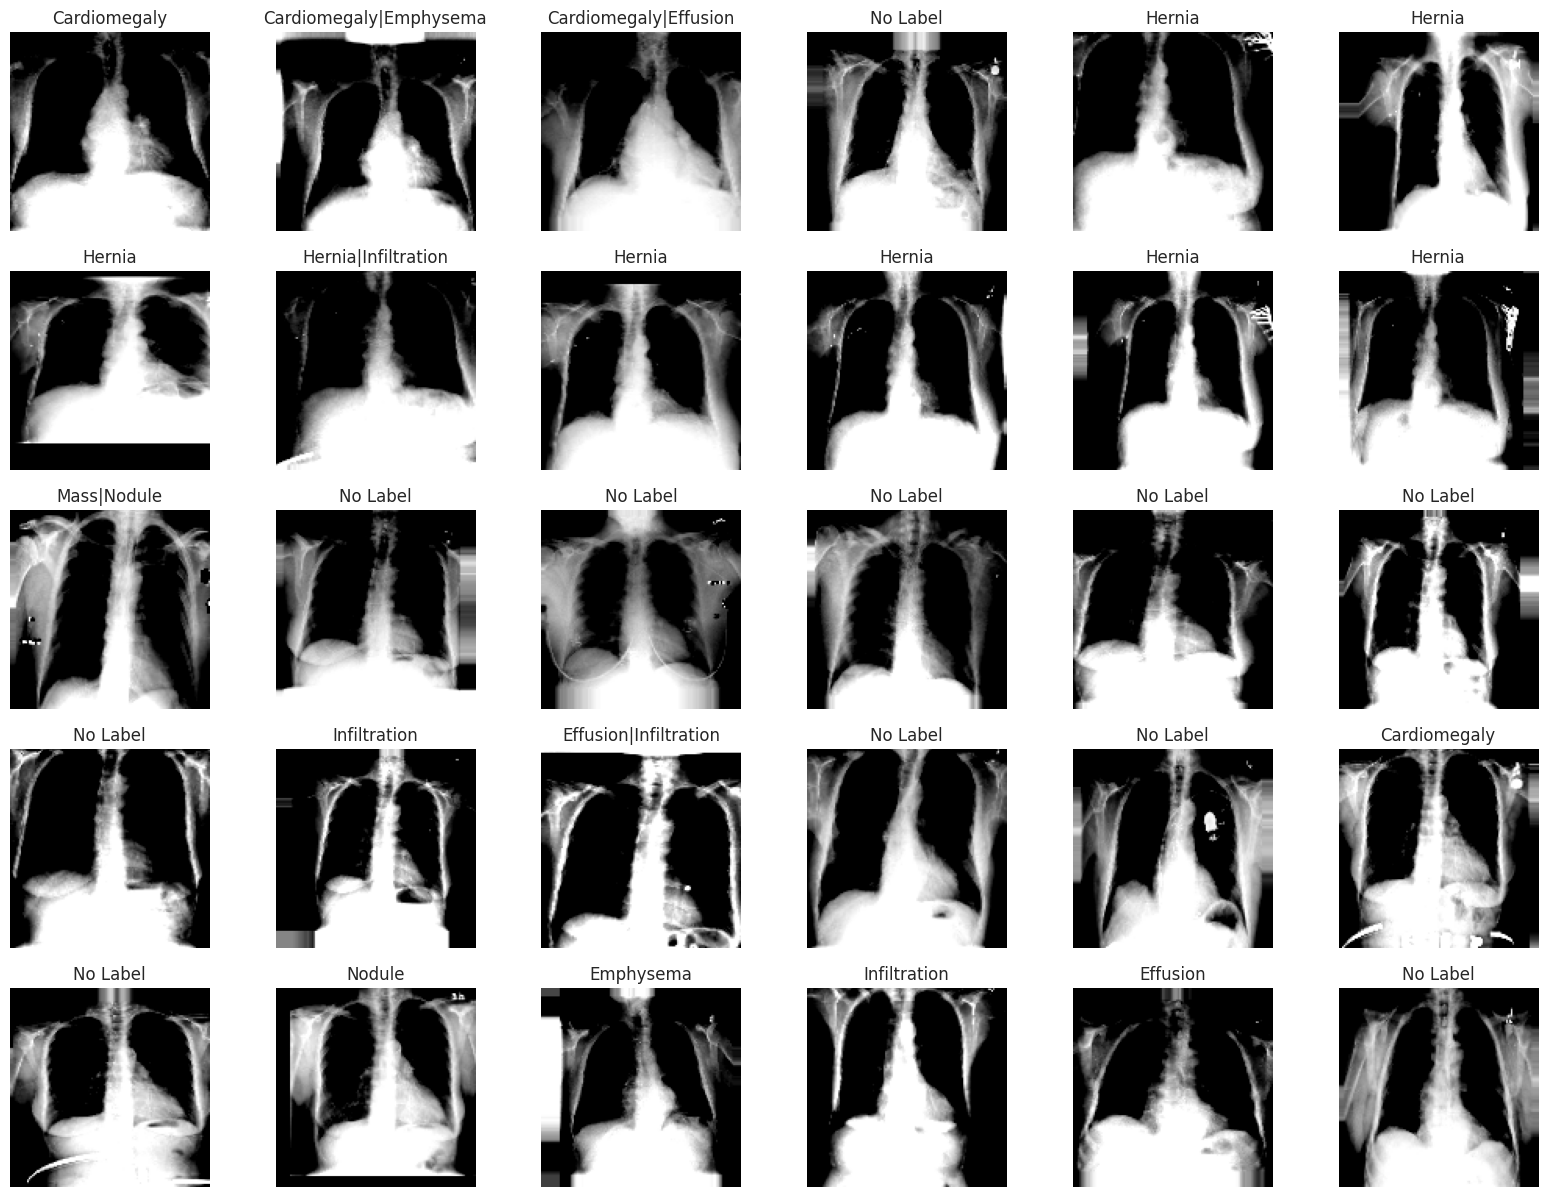

In [11]:
X, Y = train_generator.next()

def get_label(y):

    ret_labels = []
    for idx in range(len(y)):
        if y[idx]: ret_labels.append(labels[idx])
    if len(ret_labels):  return '|'.join(ret_labels)
    else: return 'No Label'

rows = int(np.floor(np.sqrt(X.shape[0])))
cols = int(X.shape[0]//rows)
fig = plt.figure(figsize=(20,15))
for i in range(1, rows*cols+1):
    fig.add_subplot(rows, cols, i)
    plt.imshow(X[i-1], cmap='gray')
    plt.title(get_label(Y[i-1]))
    plt.axis(False)
    fig.add_subplot

<a name='3'></a>
## Model Development

<a name='3-3'></a>
### DenseNet121

Next, we will use a pre-trained [DenseNet121](https://www.kaggle.com/pytorch/densenet121) model which we can load directly from Keras and then add two layers on top of it:
1. A `GlobalAveragePooling2D` layer to get the average of the last convolution layers from DenseNet121.
2. A `Dense` layer with `sigmoid` activation to get the prediction logits for each of our classes.

We can set our custom loss function for the model by specifying the `loss` parameter in the `compile()` function.

In [12]:
# create the base pre-trained model
base_model = DenseNet121(weights='../input/chestxray8-dataframe/densenet.hdf5', include_top=False)

x = base_model.output

# add a global spatial average pooling layer 
x = GlobalAveragePooling2D()(x)

# and a logistic layer
predictions = Dense(len(labels), activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=predictions)


In [13]:
model.load_weights("../input/chestxray8-dataframe/pretrained_model.h5")

<a name='4'></a>
## Prediction and Evaluation

In [14]:
predicted_vals = model.predict(test_generator, steps = len(test_generator), verbose = 1)
# 22378 images with batch size of 32

700/700 [==============================] - 1073s 2s/step


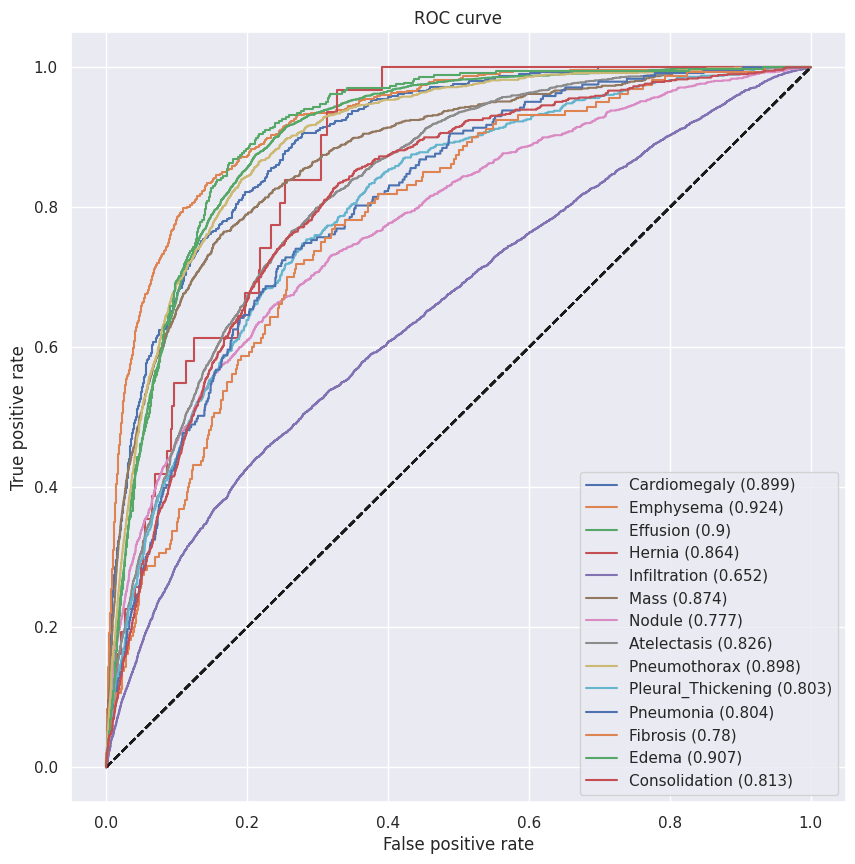

In [15]:
# get roc curve
from statistics import mean
auc_rocs, thresholds, sensitivity, specificity, accuracy, precision, recall, f1 = get_roc_curve(labels, predicted_vals, test_generator)


In [16]:
# get table of auc_rocs
from tabulate import tabulate
table = zip(labels, auc_rocs)
print(f"Mean AUC : {mean(auc_rocs)}")
print(tabulate(table, headers = ['Pathology', 'AUC'], tablefmt = 'fancy_grid'))

Mean AUC : 0.8371469327874719
╒════════════════════╤══════════╕
│ Pathology          │      AUC │
╞════════════════════╪══════════╡
│ Cardiomegaly       │ 0.899317 │
├────────────────────┼──────────┤
│ Emphysema          │ 0.923513 │
├────────────────────┼──────────┤
│ Effusion           │ 0.900322 │
├────────────────────┼──────────┤
│ Hernia             │ 0.864111 │
├────────────────────┼──────────┤
│ Infiltration       │ 0.652039 │
├────────────────────┼──────────┤
│ Mass               │ 0.874244 │
├────────────────────┼──────────┤
│ Nodule             │ 0.776567 │
├────────────────────┼──────────┤
│ Atelectasis        │ 0.825961 │
├────────────────────┼──────────┤
│ Pneumothorax       │ 0.897529 │
├────────────────────┼──────────┤
│ Pleural_Thickening │ 0.802526 │
├────────────────────┼──────────┤
│ Pneumonia          │ 0.803847 │
├────────────────────┼──────────┤
│ Fibrosis           │ 0.780347 │
├────────────────────┼──────────┤
│ Edema              │ 0.907138 │
├─────────────────

In [17]:
from tabulate import tabulate
table = zip(labels, auc_rocs, thresholds, sensitivity, specificity, accuracy, precision, recall, f1)
print(tabulate(table, headers = ['Pathology', 'AUC', 'Threshold Value', 'Sensitivity', 'Specificity', 'Accuracy', 'Precision', 'Recall', 'F1 Score'], tablefmt = 'fancy_grid'))

╒════════════════════╤══════════╤═══════════════════╤═══════════════╤═══════════════╤════════════╤═════════════╤══════════╤════════════╕
│ Pathology          │      AUC │   Threshold Value │   Sensitivity │   Specificity │   Accuracy │   Precision │   Recall │   F1 Score │
╞════════════════════╪══════════╪═══════════════════╪═══════════════╪═══════════════╪════════════╪═════════════╪══════════╪════════════╡
│ Cardiomegaly       │ 0.899317 │          0.349581 │         0.907 │      0.72078  │   0.724819 │  0.0678768  │ 0.904472 │ 0.126277   │
├────────────────────┼──────────┼───────────────────┼───────────────┼───────────────┼────────────┼─────────────┼──────────┼────────────┤
│ Emphysema          │ 0.923513 │          0.521985 │         0.834 │      0.857561 │   0.856958 │  0.125632   │ 0.832402 │ 0.218315   │
├────────────────────┼──────────┼───────────────────┼───────────────┼───────────────┼────────────┼─────────────┼──────────┼────────────┤
│ Effusion           │ 0.900322 │        

In [18]:
print(predicted_vals[0:100])


[[0.7758459  0.06117541 0.8657213  ... 0.43443716 0.48554733 0.8821399 ]
 [0.4361962  0.27121705 0.45928374 ... 0.48155868 0.37163022 0.692851  ]
 [0.4595857  0.2785409  0.27856952 ... 0.76742107 0.0670884  0.55781794]
 ...
 [0.01468775 0.17398354 0.07600563 ... 0.5065444  0.12052161 0.18078014]
 [0.02608772 0.05698996 0.03028901 ... 0.2876032  0.0247278  0.11241072]
 [0.00294448 0.41419122 0.01993395 ... 0.61753577 0.01894355 0.13482945]]
